#### Observations
- single plant ve multi plantte aynı model kurunca number of parameters değişmiyor, yani multi plantte her planti aynı weightlerle çarpıyor, bunun sonucu olarak da single plantte gelen wmapeler multi de gelemiyor, dense case'i için, CNN performansı fena değil

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import subprocess; FOLDER_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
import warnings; warnings.filterwarnings("ignore")
import sys, os; sys.path.append(os.path.dirname(f'{FOLDER_PATH}/utils')); sys.path.append(os.path.dirname(f'{FOLDER_PATH}/scripts'))

In [90]:
import tensorflow as tf
from tensorflow.keras import models, layers
from utils.base_helpers import read_data, split_data, plot_metrics
from utils.tf_helpers import WindowGenerator, compile_and_fit, calculate_plantwise_wmape, plot_plantwise_predictions
from scripts.tf_models import BaseTFModel

In [16]:
df = read_data(generate_speed_angle=True, add_lagged=True, number_of_plants=10)

Selected plants:
 [969, 968, 1518, 1484, 1507, 1508, 1527, 672, 1537, 2180]


In [17]:
train_df_np, valid_df_np, test_df_np = split_data(df, train_ratio=0.8, valid_ratio=0.1, scaler="minmax")

Train start and end dates:  2019-01-26 03:00:00 2021-06-22 09:00:00
Validation start and end dates:  2021-06-22 10:00:00 2021-10-10 04:00:00
Test start and end dates:  2021-10-10 05:00:00 2022-01-27 23:00:00


In [18]:
OUT_STEPS = 24
INPUT_WIDTH = 48

window = WindowGenerator(
    train_df=train_df_np, valid_df=valid_df_np, test_df=test_df_np, 
    columns=[col for col in df.columns if col != "rt_plant_id"],
    input_width=INPUT_WIDTH, label_width=24, shift=0, label_columns=["production"])
window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['production']

In [19]:
val_performance = {}
performance = {}

# Dense

## Linear2

In [21]:
class Linear2(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Dense(self.OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
        model.add(layers.Dropout(0.2))
        return model
    
model = Linear2(window).model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 48, 10, 17)        0         
                                                                 
 dense_3 (Dense)             (None, 48, 10, 24)        432       
                                                                 
 dropout_1 (Dropout)         (None, 48, 10, 24)        0         
                                                                 
 end-------- (Reshape)       (None, 10, 1152)          0         
                                                                 
 dense_4 (Dense)             (None, 10, 24)            27672     
                                                                 
 permute_8 (Permute)         (None, 24, 10)            0         
                                                                 
 reshape_4 (Reshape)         (None, 24, 10, 1)        

In [ ]:
class Linear3(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Dense(16, kernel_initializer=tf.initializers.zeros()))
        model.add(layers.Dropout(0.2))
        return model
    
model = Linear3(window).model
model.summary()

In [22]:
val_performance = {}
performance = {}

param_list = [
    {"loss": "mse", "optimizer": "rmsprop"},
    {"loss": "mse", "optimizer": "adam"},
]

for param_dict in param_list:
    model, history = compile_and_fit(model, window, max_epochs=10, verbose=1, **param_dict)
    val_performance["-".join(param_dict.values())] = model.evaluate(window.valid)
    performance["-".join(param_dict.values())] = model.evaluate(window.test)


Epoch 1/10
      0/Unknown - 2s 0s/sample - loss: 0.0885 - wmape: 0.6689
Epoch 1: val_wmape improved from inf to 0.50082, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 2s 7ms/sample - loss: 0.0885 - wmape: 0.6689 - val_loss: 0.0738 - val_wmape: 0.5008
Epoch 2/10
  0/329 [..............................] - ETA: 0s - loss: 0.0815 - wmape: 0.6359
Epoch 2: val_wmape improved from 0.50082 to 0.47693, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 2s 6ms/sample - loss: 0.0814 - wmape: 0.6361 - val_loss: 0.0675 - val_wmape: 0.4769
Epoch 3/10
  0/329 [..............................] - ETA: 0s - loss: 0.0796 - wmape: 0.6282
Epoch 3: val_wmape improved from 0.47693 to 0.47612, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 2s 6ms/sample - loss: 0.0795 - wmape: 0.6282 - val_loss: 0.0682 - val_wmape: 0.4761
Epoch 4/10
  0/3

# CNN

## Conv4

In [23]:
CONV_WIDTH = 5

class Conv4(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Conv2D(64, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        model.add(layers.Conv2D(32, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        return model
    
model = Conv4(window).model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 48, 10, 17)        0         
                                                                 
 permute_9 (Permute)         (None, 10, 48, 17)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 48, 64)        27264     
                                                                 
 permute_10 (Permute)        (None, 48, 64, 10)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 32, 10)       0         
 2D)                                                             
                                                                 
 permute_11 (Permute)        (None, 10, 24, 32)        0         
                                                      

In [24]:
model, history = compile_and_fit(model, window, max_epochs=10, verbose=1, loss="mse", optimizer="adam")
val_performance["CNN"] = model.evaluate(window.valid)
performance["CNN"] = model.evaluate(window.test)

Epoch 1/10
      0/Unknown - 16s 0s/sample - loss: 0.0443 - wmape: 0.4254
Epoch 1: val_wmape improved from inf to 0.29734, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 16s 49ms/sample - loss: 0.0443 - wmape: 0.4254 - val_loss: 0.0303 - val_wmape: 0.2973
Epoch 2/10
  0/329 [..............................] - ETA: 0s - loss: 0.0260 - wmape: 0.3219
Epoch 2: val_wmape improved from 0.29734 to 0.28245, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 16s 49ms/sample - loss: 0.0260 - wmape: 0.3219 - val_loss: 0.0275 - val_wmape: 0.2824
Epoch 3/10
  0/329 [..............................] - ETA: 0s - loss: 0.0233 - wmape: 0.3025
Epoch 3: val_wmape improved from 0.28245 to 0.26848, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 16s 49ms/sample - loss: 0.0233 - wmape: 0.3024 - val_loss: 0.0248 - val_wmape: 0.2685
Epoch 4/1

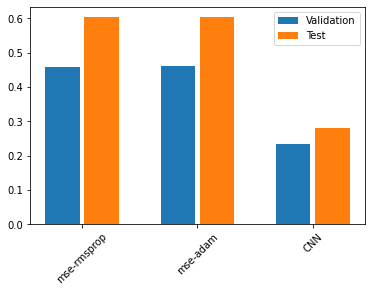

In [25]:
plot_metrics(performance, val_performance)

In [89]:
wmape_df = calculate_plantwise_wmape(model, window, selected_plants=df.rt_plant_id.unique())
wmape_df

,rt_plant_id,wmape,wmape_val
1,968,0.262608,0.269929
2,969,0.263021,0.199416
4,1507,0.264555,0.261589
5,1508,0.271978,0.318705
6,1518,0.277216,0.198515
0,672,0.278018,0.314294
7,1527,0.282388,0.180798
9,2180,0.291294,0.192010
8,1537,0.295300,0.286339
3,1484,0.299170,0.194989


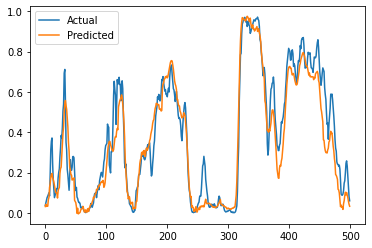

In [92]:
plot_plantwise_predictions(model, window.test)

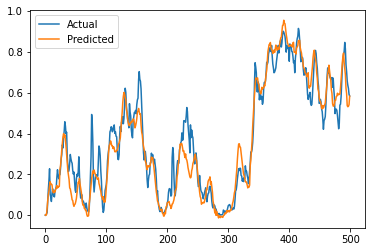

In [93]:
plot_plantwise_predictions(model, window.valid)

# Recurrent

## RNN3

In [123]:
class RNN3(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Reshape((self.window.number_of_plants, -1)))
        model.add(layers.Permute((2,1)))
        model.add(layers.MaxPooling1D(2))
        model.add(layers.Permute((2,1)))
        model.add(layers.LSTM(32, return_sequences=True))
        model.add(layers.LSTM(24, return_sequences=True))
        return model
    
model = RNN3(window).model
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 48, 10, 17)        0         
                                                                 
 permute_67 (Permute)        (None, 10, 48, 17)        0         
                                                                 
 reshape_39 (Reshape)        (None, 10, 816)           0         
                                                                 
 permute_68 (Permute)        (None, 816, 10)           0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 408, 10)          0         
 1D)                                                             
                                                                 
 permute_69 (Permute)        (None, 10, 408)           0         
                                                     

In [124]:
history = compile_and_fit(model, window)

Epoch 1/50
      0/Unknown - 7s 0s/sample - loss: 0.0871 - wmape: 0.6613
Epoch 1: val_wmape improved from inf to 0.42017, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 7s 22ms/sample - loss: 0.0869 - wmape: 0.6603 - val_loss: 0.0547 - val_wmape: 0.4202
Epoch 2/50
  0/329 [..............................] - ETA: 0s - loss: 0.0549 - wmape: 0.5069
Epoch 2: val_wmape improved from 0.42017 to 0.38428, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 3s 10ms/sample - loss: 0.0549 - wmape: 0.5065 - val_loss: 0.0468 - val_wmape: 0.3843
Epoch 3/50
  0/329 [..............................] - ETA: 0s - loss: 0.0481 - wmape: 0.4662
Epoch 3: val_wmape did not improve from 0.38428
329/329 [==============================] - 3s 10ms/sample - loss: 0.0481 - wmape: 0.4659 - val_loss: 0.0465 - val_wmape: 0.3878
Epoch 4/50
  0/329 [..............................] - ETA: 0s - loss: 0.0437 - wm

In [126]:
val_performance['RNN3'] = model.evaluate(window.valid)
performance['RNN3'] = model.evaluate(window.test)


2/2 [==============================] - 0s 9ms/step - loss: 0.0378 - wmape: 0.3402
